In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [2]:
from src.utils.auxiliary import flatten_series
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
from projects.ephys.population import to_color

In [28]:
mpl.rcParams.update({'font.size': 8})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [5]:
%matplotlib inline

# Load data

In [6]:
hffm_savepath = '/home/niell_lab/Desktop'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_0411822_sdf')

reading from /home/niell_lab/Desktop/hffm_0411822_sdf.pickle


In [7]:
ltdk_savepath = '/home/niell_lab/Desktop'
ltdk = Population(savepath=ltdk_savepath)
ltdk.load(fname='ltdk_0411822_sdf')

reading from /home/niell_lab/Desktop/ltdk_0411822_sdf.pickle


In [35]:
pdf = PdfPages('/home/niell_lab/Desktop/paperfigs_042022.pdf')

# New colormap

In [9]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))

In [10]:
cat_cmap = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}

# for plots shoting continous scatter of 
# for STAs or anything like that: seismic
# cmap for continous plots sorted by peak time: coolwarm (it has grey betwen the tow calues and diverges symetriclly)

In [11]:
psth_bins = np.arange(-1,1.001,1/1000)

# Update the optic flow data

In [ ]:
def add_available_optic_flow_data(self, use_lag=2):
        """
        use_lag is the index--not the value
        so use_lag=2 is time lag 0msec
        """
        self.data['has_optic_flow'] = False
        self.data['has_topdown_optic_flow'] = False
        self.data['FmLt_flowvec_scale'] = None

        movement_state_list = ['full','active_gyro','inactive_gyro','running_forward','running_backward','fine_motion','immobile']
        
        dummy_vec = np.zeros([40,60,2])
        vec_series = pd.Series([])
        dummy_amp = np.zeros([40,60])
        amp_series = pd.Series([])
        for i in range(len(self.data)):
            vec_series[i] = dummy_vec.astype(object)
            amp_series[i] = dummy_amp.astype(object)

        for movement_state in movement_state_list:
            self.data['FmLt_optic_flow_'+movement_state+'_vec'] = vec_series.astype(object)
            self.data['FmLt_optic_flow_'+movement_state+'_amp'] = amp_series.astype(object)
        
        recordings = self.data['original_session_path'].unique()
        recordings = [os.path.join(x, 'fm1') for x in recordings]
        for i, recording_path in enumerate(recordings):
            flow_files = find('*optic_flow.npz', recording_path)
            if flow_files:
                print('reading '+flow_files[0])
                flow_data = np.load(flow_files[0])
                # optic flow w/ topdown tracking, or only using gyro?
                if 'running_forward_vec' in flow_data.files:
                    topdown_flow = True
                else:
                    topdown_flow = False

                if topdown_flow:
                    movement_state_dict = {'full_vec':flow_data['full_vec'],'full_amp':flow_data['full_amp'],
                                        'active_gyro_vec':flow_data['active_gyro_vec'],'active_gyro_amp':flow_data['active_gyro_amp'],
                                        'inactive_gyro_vec':flow_data['inactive_gyro_vec'],'inactive_gyro_amp':flow_data['inactive_gyro_amp'],
                                        'running_forward_vec':flow_data['running_forward_vec'],'running_forward_amp':flow_data['running_forward_amp'],
                                        'running_backward_vec':flow_data['running_backward_vec'],'running_backward_amp':flow_data['running_backward_amp'],
                                        'fine_motion_vec':flow_data['fine_motion_vec'],'fine_motion_amp':flow_data['fine_motion_amp'],
                                        'immobile_vec':flow_data['immobile_vec'],'immobile_amp':flow_data['immobile_amp']}
                    movement_state_list = ['full','active_gyro','inactive_gyro','running_forward','running_backward','fine_motion','immobile']
                elif not topdown_flow:
                    movement_state_dict = {'full_vec':flow_data['full_vec'],'full_amp':flow_data['full_amp'],
                                        'active_gyro_vec':flow_data['active_gyro_vec'],'active_gyro_amp':flow_data['active_gyro_amp'],
                                        'inactive_gyro_vec':flow_data['inactive_gyro_vec'],'inactive_gyro_amp':flow_data['inactive_gyro_amp']}
                    movement_state_list = ['full','active_gyro','inactive_gyro']

                origsess, _ = os.path.split(recording_path)

                for movement_state in movement_state_list:
                    flow_vec = movement_state_dict[movement_state+'_vec'] # shape is [unit, lag, x, y, U/V]
                    flow_amp = movement_state_dict[movement_state+'_amp'] # shape is [unit, lag, x, y]
                    if movement_state=='full':
                        vec_scale = np.zeros(np.size(flow_vec, 0))
                    flow_arr_ind = 0
                    use_inds = [os.path.samefile(p, origsess) for p in self.data['original_session_path']]
                    for ind, _ in self.data[use_inds].iterrows():
                        self.data.at[ind, 'FmLt_optic_flow_'+movement_state+'_vec'] = flow_vec[flow_arr_ind, use_lag].astype(object)
                        self.data.at[ind, 'FmLt_optic_flow_'+movement_state+'_amp'] = flow_amp[flow_arr_ind, use_lag].astype(object)
                        if movement_state=='full':
                            vec_scale[flow_arr_ind] = np.max(np.sqrt((flow_vec[flow_arr_ind, use_lag, :, 0].flatten()**2) + (flow_vec[flow_arr_ind, use_lag, :, 1].flatten()**2))) # U**2 + V**2
                        flow_arr_ind += 1
                    if movement_state=='full':
                        max_vec_scale = np.max(vec_scale.flatten())
                        for ind, _ in self.data[use_inds].iterrows():
                            self.data.at[ind, 'FmLt_flowvec_scale'] = max_vec_scale
                            self.data.at[ind, 'has_optic_flow'] = True
                            self.data.at[ind, 'has_topdown_optic_flow'] = topdown_flow

# Fig 1

In [12]:
psth_wind = {
    'start_base': 850, # -150msec
    'zero': 1000, # 0msec
    'end_evok': 1250 # +250msec
}
def normalize_psth(psth, raw_pref=None):
    if raw_pref is None:
        raw_pref = psth.copy()
    norm_psth = (psth - np.nanmean(psth[psth_wind['start_base']:psth_wind['zero']].astype(float))) / np.nanmax(raw_pref[psth_wind['zero']:psth_wind['end_evok']].astype(float))
    return norm_psth

In [13]:
for ind, row in hffm.data.iterrows():
    if row['pref_gazeshift_direction']=='L':
        pref_dir = 'left'
        nonpref_dir = 'right'
    elif row['pref_gazeshift_direction']=='R':
        pref_dir = 'right'
        nonpref_dir = 'left'
    
    hffm.data.at[ind, 'pref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    hffm.data.at[ind, 'nonpref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    
    hffm.data.at[ind, 'pref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    hffm.data.at[ind, 'nonpref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    
    hffm.data.at[ind, 'norm_Rc_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    
    

In [36]:
demo = hffm.data[hffm.data['session']=='102621_J558NC_control_Rig2'].iloc[0]

In [37]:
def time_to_ind(eyeT, eventT):
    eventInds = np.zeros(eventT.size)
    for i, t in enumerate(eventT):
        eventInds[i] = np.nanargmin(np.abs(eyeT-t))
    return eventInds

In [38]:
np.nanmax(demo['FmLt_eyeT'])/60

63.56131199166666

In [39]:
dHead_data = demo['FmLt_dHead']
dEye_data = demo['FmLt_dEye_dps']
dGaze_data = demo['FmLt_dGaze']
eyeT = demo['FmLt_eyeT']

left = demo['FmLt_gazeshift_left_saccTimes_dHead']
right = demo['FmLt_gazeshift_right_saccTimes_dHead']
comp = np.hstack([demo['FmLt_comp_left_saccTimes_dHead'], demo['FmLt_comp_right_saccTimes_dHead']])
# other = np.isin(eyeT, np.hstack([comp, left, right]), invert=True, assume_unique=True)

In [40]:
plotinds = np.sort(np.random.choice(np.arange(eyeT.size), size=int(np.ceil(eyeT.size/50)), replace=False))

In [41]:
plot_eyeT = eyeT[plotinds]

In [42]:
left_dHead = [dHead_data[i] for i in plotinds if np.isin(eyeT[i], left)]

In [43]:
right_dHead = [dHead_data[i] for i in plotinds if np.isin(eyeT[i], right)]
left_dEye = [dEye_data[i] for i in plotinds if np.isin(eyeT[i], left)]
right_dEye = [dEye_data[i] for i in plotinds if np.isin(eyeT[i], right)]

In [44]:
nongazeinds = [i for i in plotinds if np.isin(eyeT[i], np.hstack([left, right]), invert=True)]

In [45]:
nongaze_dEye = dEye_data[nongazeinds]
nongaze_dHead = dHead_data[nongazeinds]

In [50]:
demo['FmLt_comp_right_saccTimes_dHead'].size

22093

In [53]:
np.nanmax(demo['FmLt_eyeT'])/60

63.56131199166666

In [54]:
len(hffm.data.index.values)

716

### Make the figure

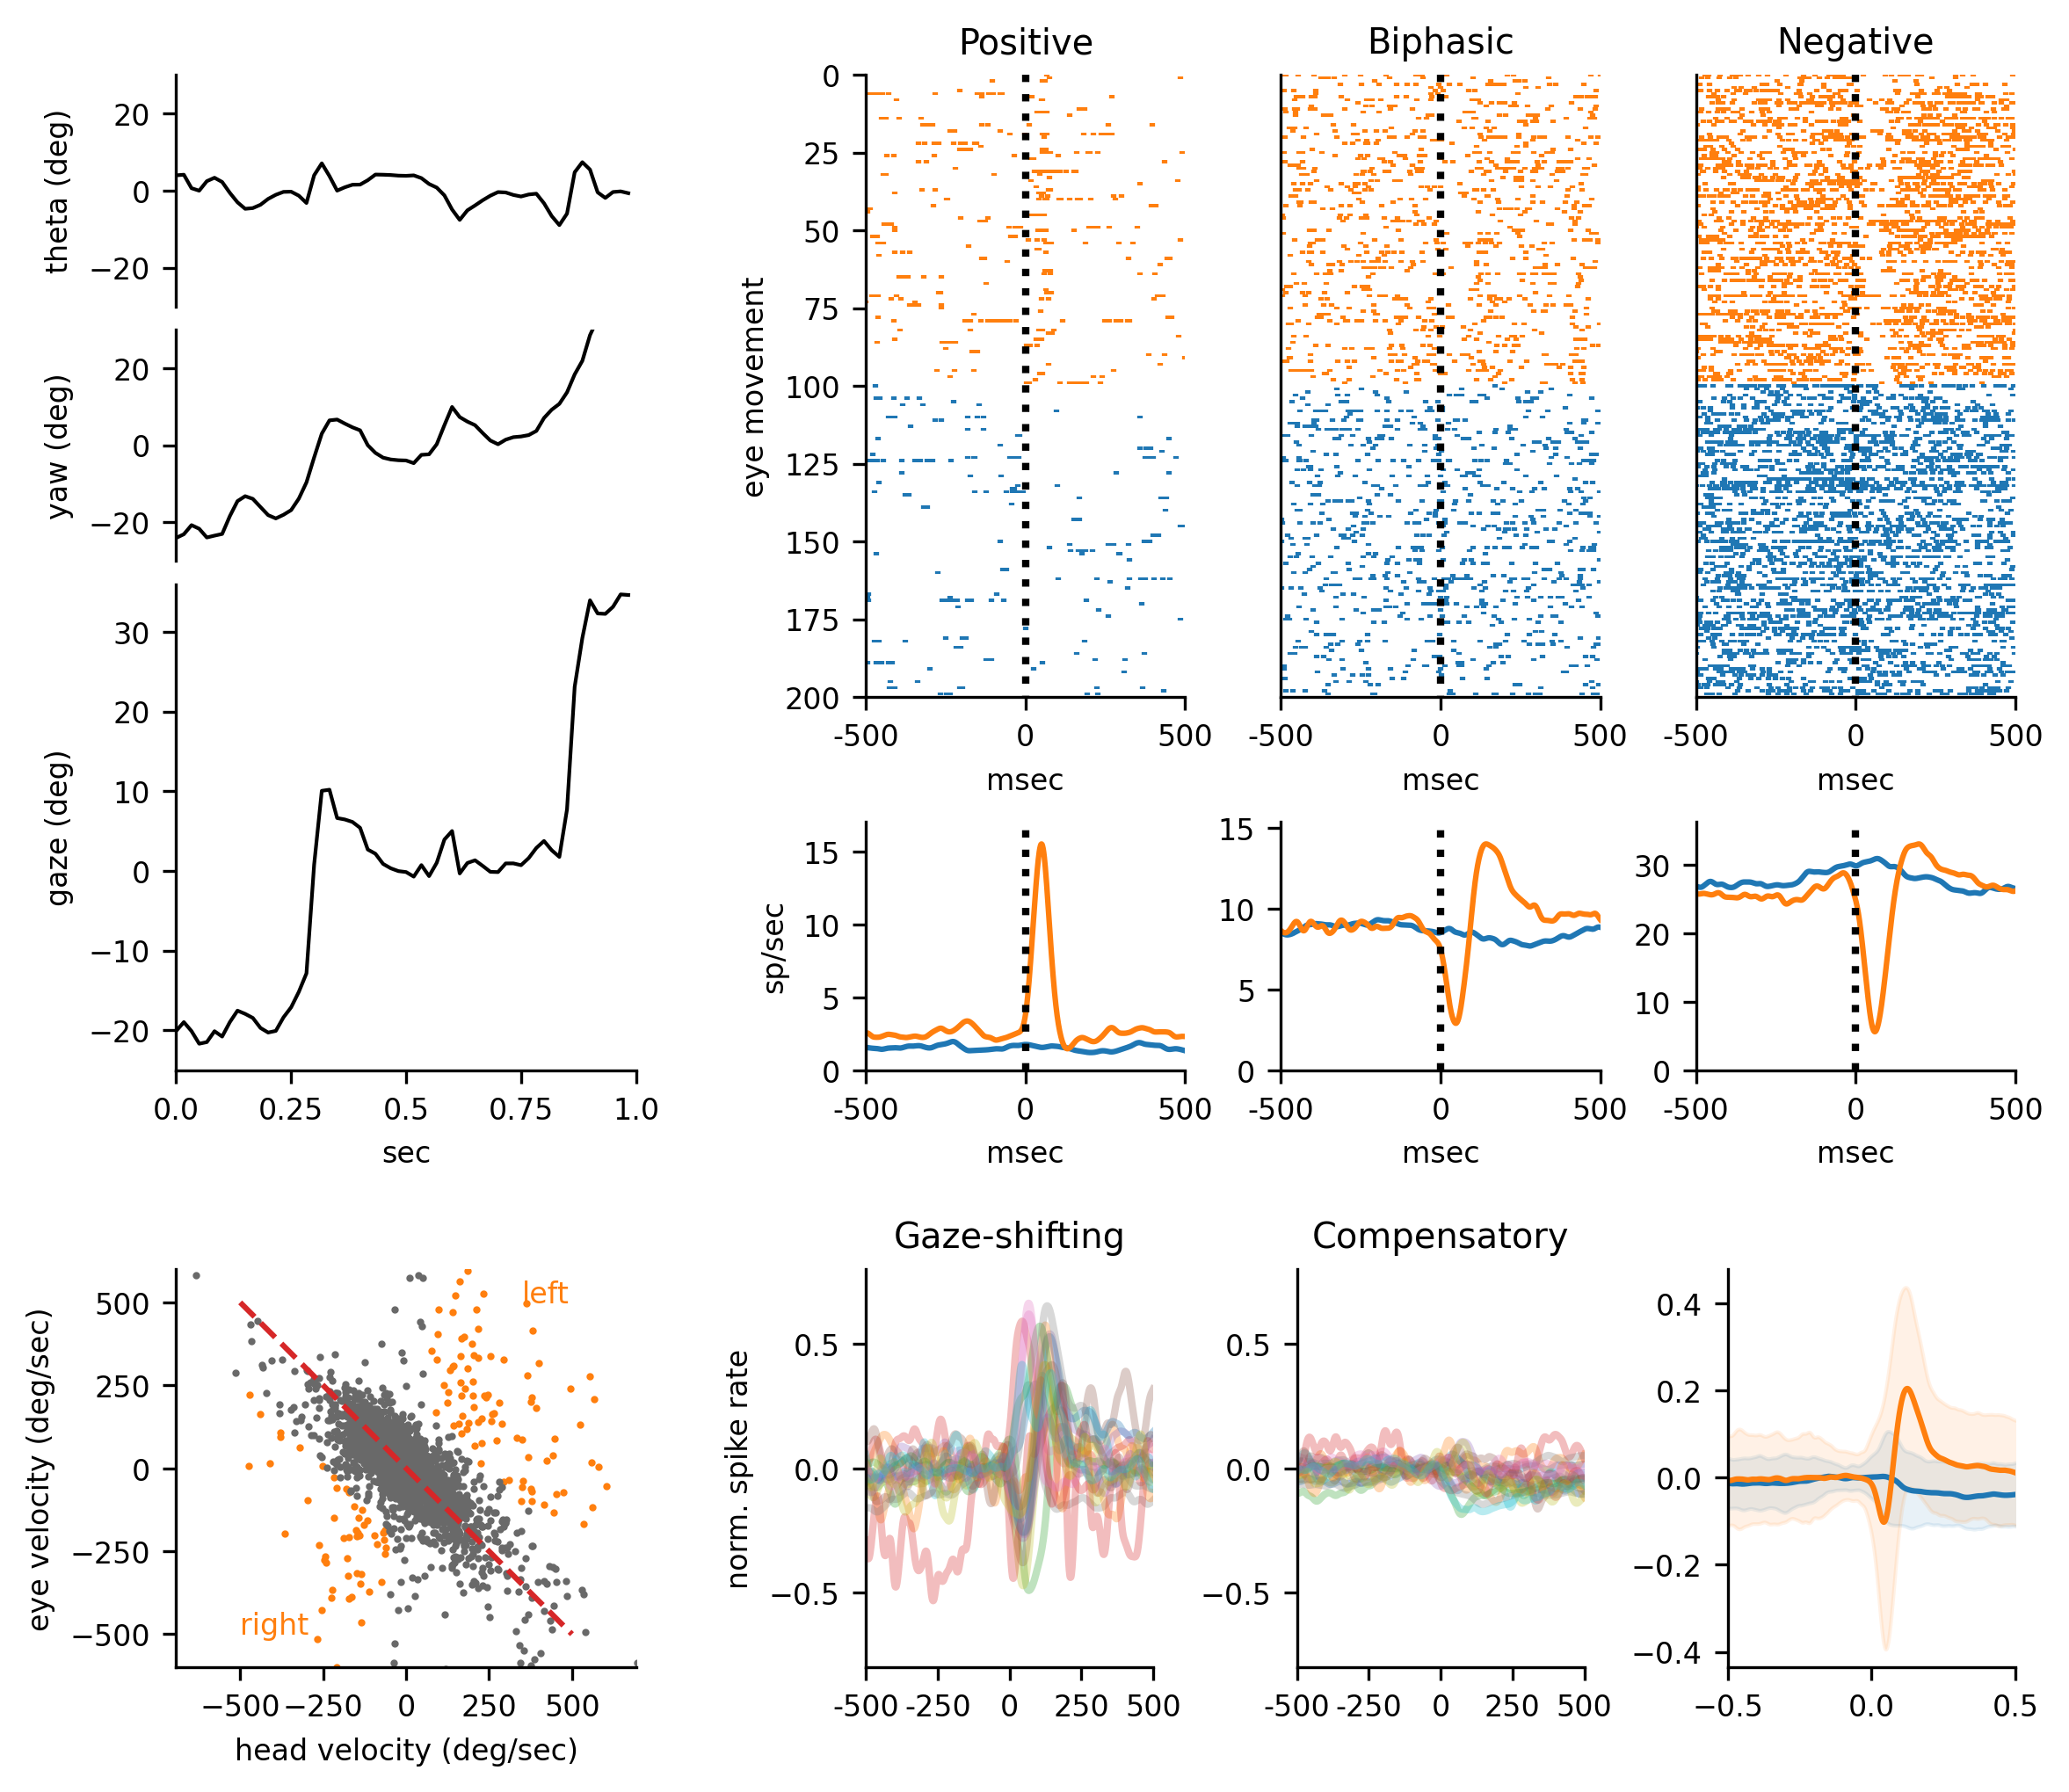

In [46]:
fig1 = plt.figure(constrained_layout=False, figsize=(9,8), dpi=300)
fig1spec = gridspec.GridSpec(nrows=3, ncols=3, figure=fig1, wspace=0.5, hspace=0.5)

fig1Cspec = gridspec.GridSpecFromSubplotSpec(4,1,subplot_spec=fig1spec[:2,0], wspace=0, hspace=0.1)
ax_theta = fig1.add_subplot(fig1Cspec[0,0])
ax_yaw = fig1.add_subplot(fig1Cspec[1,0])
ax_gaze = fig1.add_subplot(fig1Cspec[2:,0])

fig1Dspec = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=fig1spec[2,0], wspace=0, hspace=0)
ax_dEyeHead = fig1.add_subplot(fig1Dspec[0,0])

fig1E2Fspec = gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=fig1spec[:2,1:], wspace=0.3, hspace=0.5)
ax_pos_raster = fig1.add_subplot(fig1E2Fspec[0:2,0])
ax_biph_raster = fig1.add_subplot(fig1E2Fspec[0:2,1])
ax_neg_raster = fig1.add_subplot(fig1E2Fspec[0:2,2])
ax_pos_psth = fig1.add_subplot(fig1E2Fspec[2,0])
ax_biph_psth = fig1.add_subplot(fig1E2Fspec[2,1])
ax_neg_psth = fig1.add_subplot(fig1E2Fspec[2,2])

fig1Gspec = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=fig1spec[2,1:], wspace=0.5, hspace=0)
ax_ex_gaze = fig1.add_subplot(fig1Gspec[0,0])
ax_ex_comp = fig1.add_subplot(fig1Gspec[0,1])
ax_gaze_vs_comp = fig1.add_subplot(fig1Gspec[:,2])

start = 2090 #2100
win = 60 # frames, not sec
ex_units = [185,82,155]
ex_units_direcprefs = ['left','right','left']

theta_data = demo['FmLt_theta'][start:start+win]
theta_data = theta_data - np.nanmean(theta_data)
ax_theta.plot(theta_data, 'k-', linewidth=1, scaley=10)
ax_theta.set_xlim([0,60]); ax_theta.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_theta.set_ylabel('theta (deg)')
ax_theta.set_ylim([-30,30])
ax_theta.axes.get_xaxis().set_visible(False)
ax_theta.axes.spines.bottom.set_visible(False)

pYaw = np.nancumsum(demo['FmLt_dHead'][start:start+win]*0.016)
pYaw = pYaw - np.nanmean(pYaw)
ax_yaw.plot(pYaw, 'k-', linewidth=1)
ax_yaw.set_xlim([0,60])
ax_yaw.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_yaw.set_ylabel('yaw (deg)')
ax_yaw.axes.get_xaxis().set_visible(False)
ax_yaw.axes.spines.bottom.set_visible(False)
ax_yaw.set_ylim([-30,30])

ax_gaze.plot(pYaw + theta_data, 'k-', linewidth=1)
ax_gaze.set_xlim([0,60])
ax_gaze.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_gaze.set_ylabel('gaze (deg)')
ax_gaze.set_ylim([-25,36])
ax_gaze.set_xlabel('sec')

ax_dEyeHead.plot(left_dHead, left_dEye, '.', color='tab:orange', markersize=2) # left
ax_dEyeHead.plot(right_dHead, right_dEye, '.', color='tab:orange', markersize=2) # right
ax_dEyeHead.plot(nongaze_dHead, nongaze_dEye, '.', color='dimgrey', markersize=2) # NOT left or right gaze shift
ax_dEyeHead.axis('equal')
ax_dEyeHead.set_xlim([-600,600])
ax_dEyeHead.set_ylim([-600,600])
ax_dEyeHead.set_xlabel('head velocity (deg/sec)')
ax_dEyeHead.set_ylabel('eye velocity (deg/sec)')
ax_dEyeHead.plot([-500,500],[500,-500], linestyle='dashed', color='tab:red')
ax_dEyeHead.annotate('left', xy=[350,500], color='tab:orange')
ax_dEyeHead.annotate('right', xy=[-500,-500], color='tab:orange')
ax_dEyeHead.set_xticks(np.linspace(-500,500,5))
ax_dEyeHead.set_yticks(np.linspace(-500,500,5))

num_movements = 100
raster_panels = [ax_pos_raster, ax_biph_raster, ax_neg_raster]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.data.iloc[u]
    raster_panel = raster_panels[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead'.format(LR)].copy()
    compmovs = np.hstack([row['FmLt_comp_left_saccTimes_dHead'], row['FmLt_comp_right_saccTimes_dHead']])
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_cp = np.random.choice(compmovs, size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.vlines(sp, n-0.5, n+0.5, color='tab:orange')

    for n, s in enumerate(plot_cp):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.vlines(sp, (num_movements+n)-0.5, (num_movements+n)+0.5, color='tab:blue')
    
    height = num_movements*2
    raster_panel.set_ylim([height, 0])
    raster_panel.vlines(0, 0, height, color='k', linewidth=2, linestyle='dotted')
    raster_panel.set_xlabel('msec')
    if i == 0:
        raster_panel.set_ylabel('eye movement')
    else:
        raster_panel.set_yticks([])
    raster_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    raster_panel.set_title(['Positive','Biphasic','Negative'][i])
    raster_panel.set_xlim([-.5,.5])
    
    sdf_panel.plot(psth_bins, row['FmLt_comp_{}_saccPSTH_dHead'.format(LR)], color='tab:blue')
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], color='tab:orange')
    max_fr = np.nanmax(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)])*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('sp/sec')
    sdf_panel.set_xlabel('msec')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=2, linestyle='dotted')

possible_inds = hffm.data[hffm.data['movcluster']!='unresponsive'].index.values
example_inds = np.sort(np.random.choice(possible_inds, size=20, replace=False))

for ind in example_inds:
    ax_ex_gaze.plot(psth_bins, hffm.data.loc[ind,'pref_gazeshift_psth1'].astype(float), linewidth=2, alpha=0.3)
    ax_ex_comp.plot(psth_bins, hffm.data.loc[ind,'nonpref_comp_psth1'].astype(float), linewidth=2, alpha=0.3)
ax_ex_gaze.set_xlim([-.5,.5]); ax_ex_gaze.set_title('Gaze-shifting')
ax_ex_gaze.set_xticks(np.arange(-0.5,0.65,0.25), labels=np.arange(-500,650,250))
ax_ex_comp.set_xlim([-.5,.5]); ax_ex_comp.set_title('Compensatory')
ax_ex_comp.set_xticks(np.arange(-0.5,0.65,0.25), labels=np.arange(-500,650,250))
ax_ex_gaze.set_ylim([-0.8,0.8])
ax_ex_comp.set_ylim([-0.8,0.8])
ax_ex_gaze.set_ylabel('norm. spike rate')

all_comp = flatten_series(hffm.data['nonpref_comp_psth1'])
all_gaze = flatten_series(hffm.data['pref_gazeshift_psth1'])

comp_mean = np.nanmean(all_comp,0)
comp_std = np.std(all_comp,0)

gaze_mean = np.nanmean(all_gaze,0)
gaze_std = np.std(all_gaze,0)

ax_gaze_vs_comp.plot(psth_bins, comp_mean, color='tab:blue')
ax_gaze_vs_comp.fill_between(psth_bins, comp_mean-comp_std, comp_mean+comp_std, color='tab:blue', alpha=0.1)
ax_gaze_vs_comp.set_xlim([-0.5,0.5])
ax_gaze_vs_comp.plot(psth_bins, gaze_mean, color='tab:orange')
ax_gaze_vs_comp.fill_between(psth_bins, gaze_mean-gaze_std, gaze_mean+gaze_std, color='tab:orange', alpha=0.1)

fig1.savefig('/home/niell_lab/Desktop/fig1.pdf')
pdf.savefig()

# Fig 2

In [24]:
def plot_cprop_scatter(panel, prop_name, filter_by=[], row=None, use_median=False, apply_abs=False):
    for c, cluster in enumerate(['early','late','biphasic','negative','unresponsive']):
        if filter_by:
            for filt in filter_by:
                data = hffm.data[hffm.data[filt]==True]
        else:
            data = hffm.data.copy()
        data = data[prop_name][data['movcluster']==cluster]
        if apply_abs is True:
            data = np.abs(data)
        x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
        panel.plot(x_jitter, data, '.', color=cat_cmap[cluster], markersize=2)
        if use_median:
            hline = np.median(data)
        elif not use_median:
            hline = np.mean(data)
        panel.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
        panel.set_xticks(range(5), ['e','l','b','n','u'])
    if row is not None:
        panel.plot(cluster_names.index(row['movcluster']), row[prop_name], '*', color=cat_cmap[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')

In [64]:
for ind, row in hffm.data.iterrows():
    LR = row['pref_gazeshift_direction']
    if LR=='L':
        LR = 'left'
    elif LR=='R':
        LR = 'right'
    psth = row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)].astype(float)
    baseline = np.nanmedian(psth[850:1000])
    hffm.data.at[ind, 'psth_baseline'] = baseline
    hffm.data.at[ind, 'pref_gazeshift_raw_psth1'] = psth.astype(object)
for ind in hffm.data.index.values:
    hffm.data.at[ind, 'psth_peakT'] = psth_bins[np.argmax(hffm.data.loc[ind,'pref_gazeshift_raw_psth1'][1000:1250])+1000]
sorted_df = hffm.data[['psth_peakT','movcluster','pref_gazeshift_psth1','nonpref_gazeshift_psth1','pref_comp_psth1','nonpref_comp_psth1']].copy()
sorted_df.sort_values(by='psth_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['movcluster']!='unresponsive'].reset_index()
tseq_pref = flatten_series(sorted_df['pref_gazeshift_psth1'].copy())
tseq_nonpref = flatten_series(sorted_df['nonpref_gazeshift_psth1'].copy())
tseq_comp = flatten_series(sorted_df['nonpref_comp_psth1'].copy())

In [16]:
def plot_tempseq(panel, tseq, return_img=False):
    panel.set_xlabel('msec')
    panel.set_ylim([np.size(tseq,0),0])
    img = panel.imshow(tseq, cmap='coolwarm', vmin=-.9, vmax=.9)
    panel.set_xlim([800,1400])
    panel.set_xticks(np.linspace(800,1400,4), labels=np.linspace(-200,400,4).astype(int))
    panel.vlines(1000, 0, np.size(tseq,0), color='k', linestyle='dashed', linewidth=1)
    if return_img:
        return img

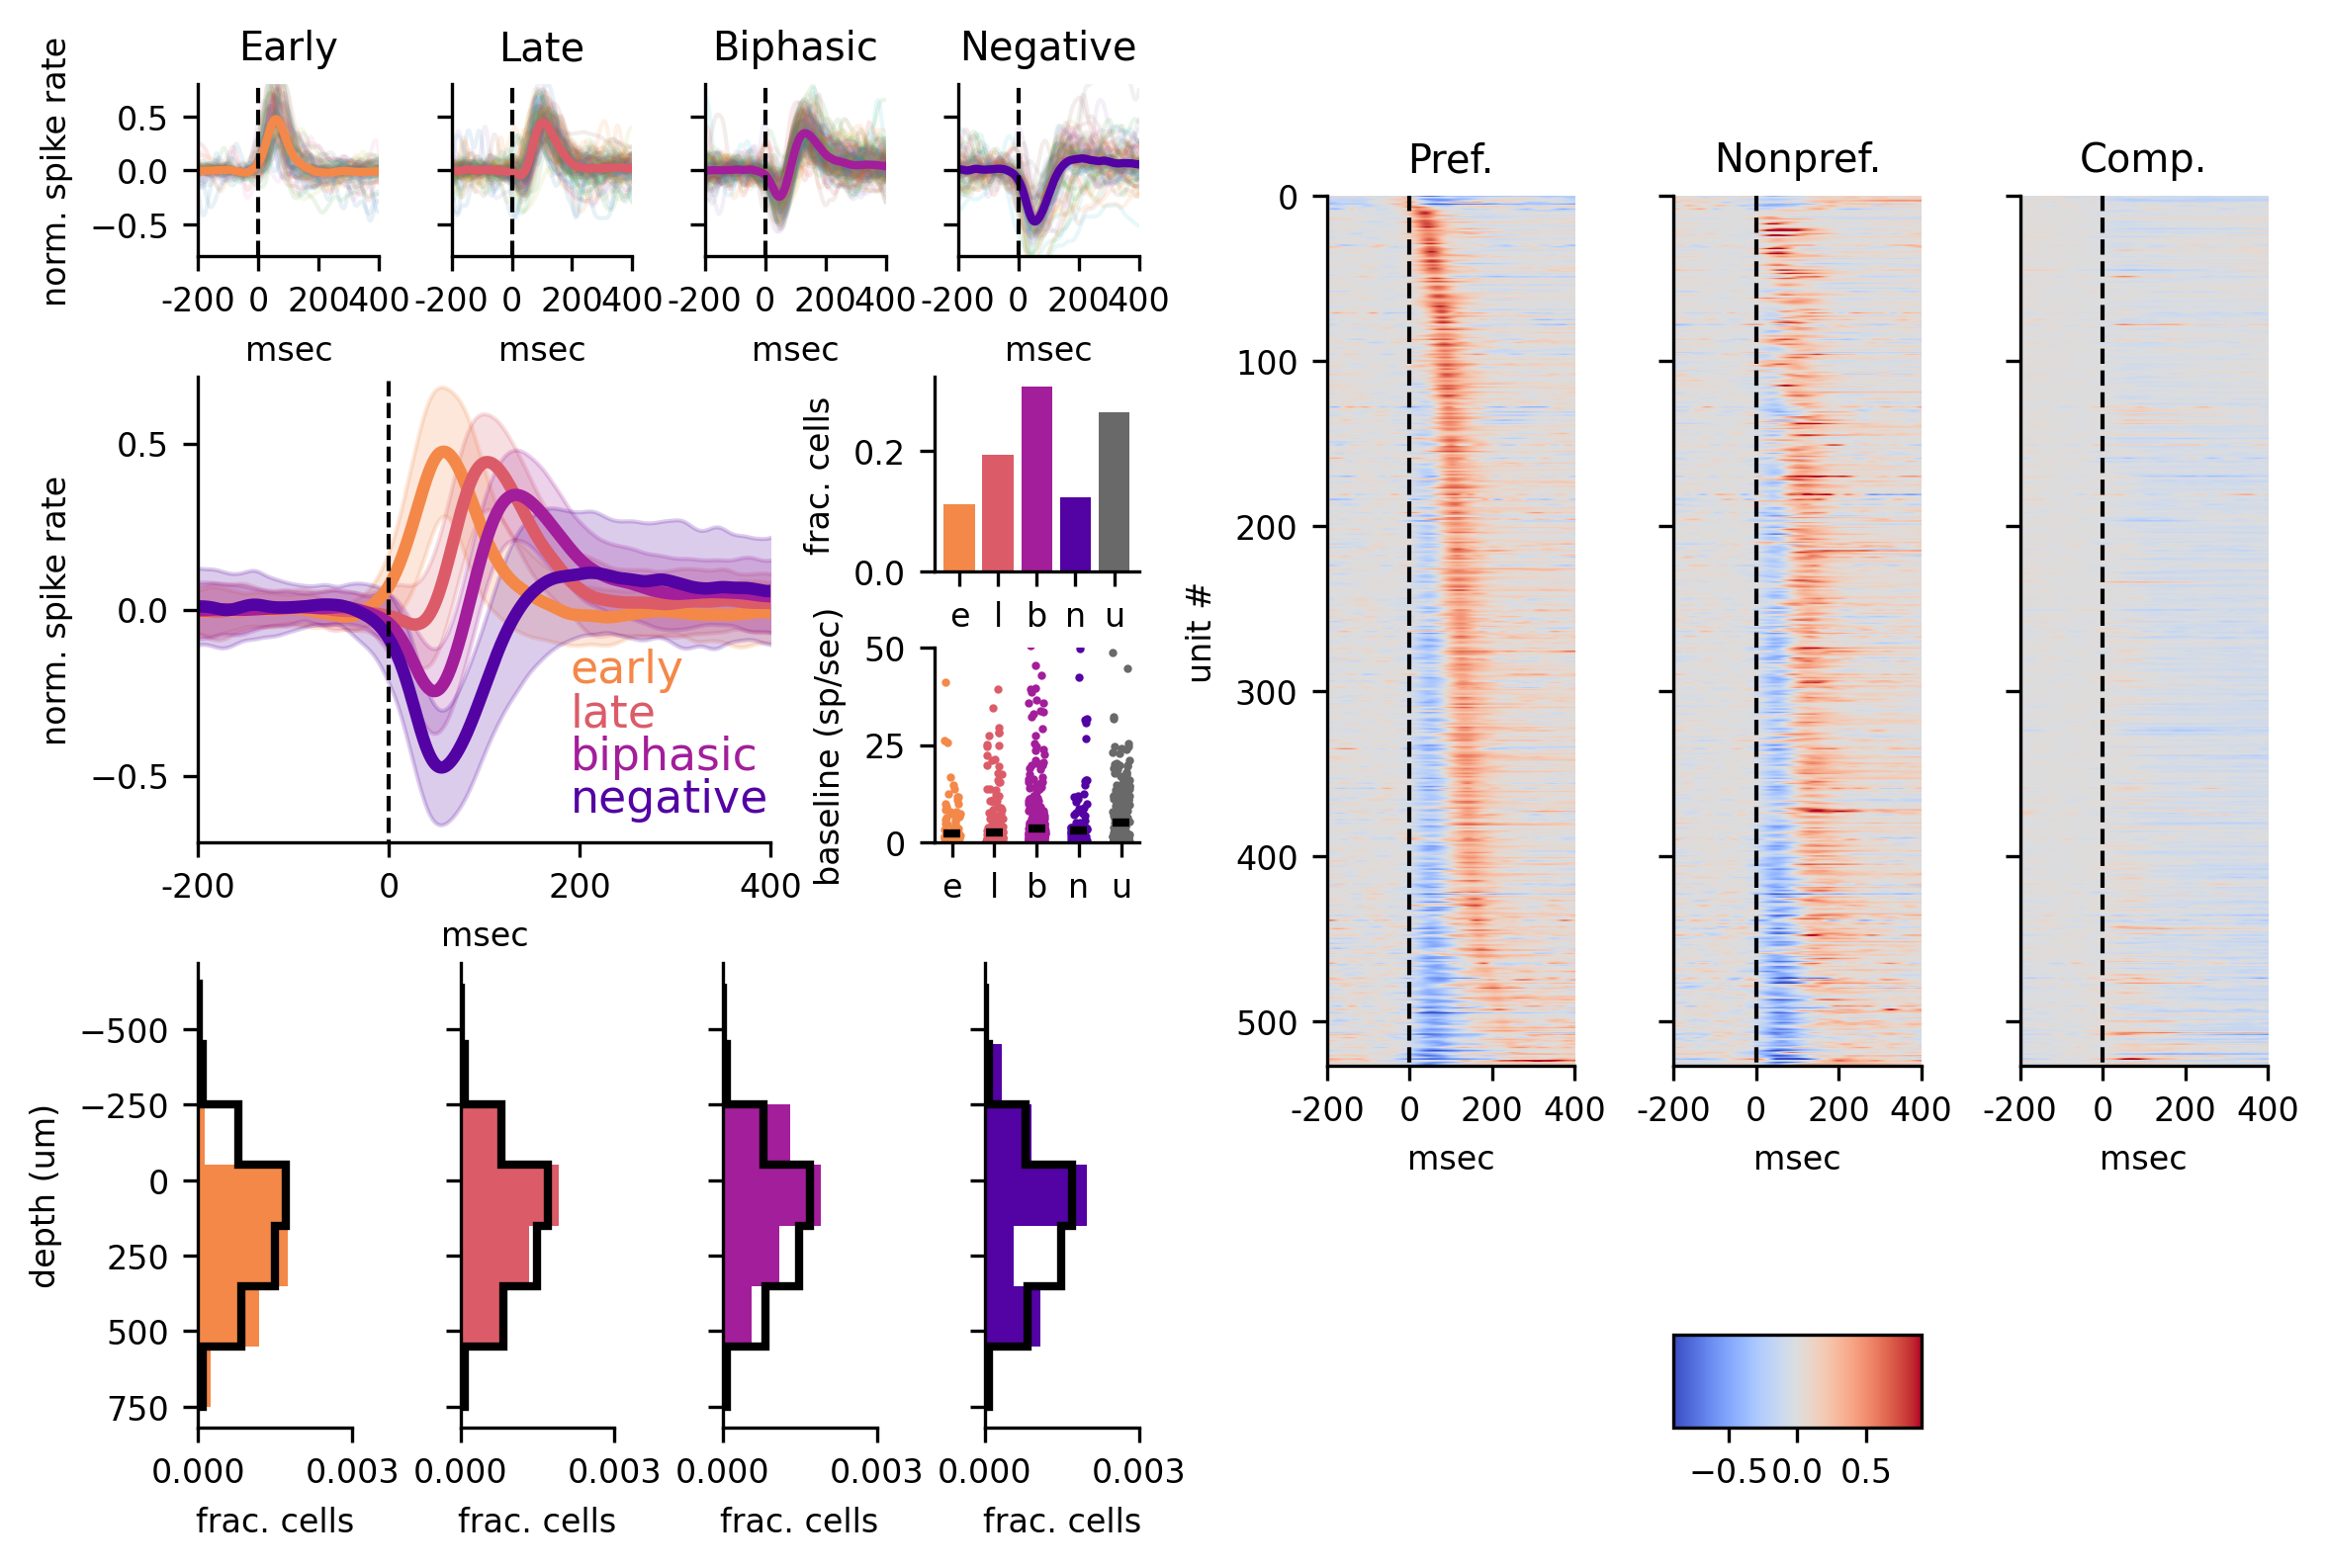

In [65]:
fig2 = plt.figure(constrained_layout=False, figsize=(9,6), dpi=300)
fig2spec = gridspec.GridSpec(nrows=5, ncols=2, figure=fig2, wspace=0.2, hspace=0.7)

fig2Aspec = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=fig2spec[0,0], wspace=0.4, hspace=0)
ax_early = fig2.add_subplot(fig2Aspec[0,0])
ax_late = fig2.add_subplot(fig2Aspec[0,1])
ax_biphasic = fig2.add_subplot(fig2Aspec[0,2])
ax_negative = fig2.add_subplot(fig2Aspec[0,3])

fig2B2Dspec = gridspec.GridSpecFromSubplotSpec(4,3, subplot_spec=fig2spec[1:3,0], wspace=0.8, hspace=1.3)
ax_clusters = fig2.add_subplot(fig2B2Dspec[:,0:2])
ax_cellcounts = fig2.add_subplot(fig2B2Dspec[0:2,2])
ax_baseline_fr = fig2.add_subplot(fig2B2Dspec[2:4,2])

fig2Espec = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=fig2spec[3:5,0], wspace=0.7, hspace=0)
ax_early_depth = fig2.add_subplot(fig2Espec[0,0])
ax_late_depth = fig2.add_subplot(fig2Espec[0,1])
ax_biphasic_depth = fig2.add_subplot(fig2Espec[0,2])
ax_negative_depth = fig2.add_subplot(fig2Espec[0,3])

fig2Fspec = gridspec.GridSpecFromSubplotSpec(6,3, subplot_spec=fig2spec[:,1], wspace=0.4, hspace=1.7)
ax_tseq_pref = fig2.add_subplot(fig2Fspec[:5,0])
ax_tseq_nonpref = fig2.add_subplot(fig2Fspec[:5,1])
ax_tseq_comp = fig2.add_subplot(fig2Fspec[:5,2])
ax_colorbar = fig2.add_subplot(fig2Fspec[5,1])

panels = [ax_early, ax_late, ax_biphasic, ax_negative]
movtypes = ['early','late','biphasic','negative']
for count, panel in enumerate(panels):
    movtype = movtypes[count]
    thisclust = hffm.data['pref_gazeshift_psth1'][hffm.data['movcluster']==movtype]
    for i, psth in enumerate(thisclust):
        panel.plot(psth_bins, psth, '-', linewidth=1, alpha=0.1)
    clustmean = np.nanmean(flatten_series(thisclust),0)
    panel.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[movtype])
    panel.set_xlim([-0.2,0.4]); panel.set_ylim([-.8,.8])
    panel.set_title(movtype.capitalize())
    if count == 0:
        panel.set_ylabel('norm. spike rate')
    else:
        panel.set_yticklabels([])
    panel.set_xlabel('msec')
    panel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    panel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))

step = 0.13
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm.data['pref_gazeshift_psth1'][hffm.data['movcluster']==name])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0)# / np.sqrt(np.size(cluster_psths,0))
    ax_clusters.plot(psth_bins, clustmean, '-', linewidth=3, color=cat_cmap[name])
    ax_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2)
ax_clusters.set_xlim([-0.2,0.4]); ax_clusters.set_ylim([-.7,.7])
ax_clusters.annotate('early', xy=[0.19,-0.22], color=cat_cmap['early'], fontsize=11)
ax_clusters.annotate('late', xy=[0.19,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
ax_clusters.annotate('biphasic', xy=[0.19,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
ax_clusters.annotate('negative', xy=[0.19,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_clusters.set_ylabel('norm. spike rate'); ax_clusters.set_xlabel('msec')
ax_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_clusters.set_yticks(np.linspace(-0.5,0.5,3))

vcounts = hffm.data['movcluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    ax_cellcounts.bar(i, vcounts[name]/np.sum(vcounts), color=cat_cmap[name])
ax_cellcounts.set_xticks(ticks=range(5), labels=['e','l','b','n','u'])
ax_cellcounts.set_ylabel('frac. cells')

plot_cprop_scatter(ax_baseline_fr, 'psth_baseline', use_median=True)
ax_baseline_fr.set_ylabel('baseline (sp/sec)')
ax_baseline_fr.set_ylim([0,50])

panels = [ax_early_depth, ax_late_depth, ax_biphasic_depth, ax_negative_depth]
names = ['early','late','biphasic','negative']
for i, panel in enumerate(panels):
    name = names[i]
    panel.hist(hffm.data['Wn_depth_from_layer5'], color='k', bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='step', linewidth=2)
    panel.hist(hffm.data['Wn_depth_from_layer5'][hffm.data['movcluster']==name],
                        color=cat_cmap[name], bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='stepfilled')
    panel.set_xlabel('frac. cells')
    if i == 0:
        panel.set_ylabel('depth (um)')
    else:
        panel.set_yticklabels([])
    panel.invert_yaxis()
    panel.set_xlim(0,0.003)
    panel.set_xticks([0,0.003])

tseq_aspect = 4
img = plot_tempseq(ax_tseq_pref, tseq_pref, return_img=True)
ax_tseq_pref.set_aspect(tseq_aspect)
ax_tseq_pref.set_title('Pref.')
ax_tseq_pref.set_ylabel('unit #')
plt.colorbar(img, cax=ax_colorbar, orientation='horizontal', aspect=1)

plot_tempseq(ax_tseq_nonpref, tseq_nonpref)
ax_tseq_nonpref.set_aspect(tseq_aspect)
ax_tseq_nonpref.set_title('Nonpref.')
ax_tseq_nonpref.set_yticklabels([])

plot_tempseq(ax_tseq_comp, tseq_comp)
ax_tseq_comp.set_aspect(tseq_aspect)
ax_tseq_comp.set_title('Comp.')
ax_tseq_comp.set_yticklabels([])

fig2.savefig('/home/niell_lab/Desktop/fig2.pdf')

In [68]:
ltdk.data['movcluster'].value_counts()

biphasic        74
unresponsive    65
negative        63
late            41
early           26
Name: movcluster, dtype: int64

In [70]:
26+41+74+63+65

269

# Fig 3

In [56]:
for ind, row in ltdk.data.iterrows():
    if row['pref_gazeshift_direction']=='L':
        pref_dir = 'left'
        nonpref_dir = 'right'
    elif row['pref_gazeshift_direction']=='R':
        pref_dir = 'right'
        nonpref_dir = 'left'
    ltdk.data.at[ind, 'pref_gazeshift_raw_psth1'] = row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)].astype(object)
    ltdk.data.at[ind, 'pref_gazeshift_raw_psth1_FmDk'] = row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)].astype(object)
    # light recording
    ltdk.data.at[ind, 'pref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'pref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    # dark recording
    ltdk.data.at[ind, 'pref_gazeshift_psth1_FmDk'] = normalize_psth(row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_gazeshift_psth1_FmDk'] = normalize_psth(row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'pref_comp_psth1_FmDk'] = normalize_psth(row['FmDk_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_comp_psth1_FmDk'] = normalize_psth(row['FmDk_comp_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    

In [57]:
for ind, row in ltdk.data.iterrows():
    psth = row['pref_gazeshift_raw_psth1'].astype(float)
    baseline = np.nanmean(psth[850:1000])
    ltdk.data.at[ind, 'psth_baseline'] = baseline
for ind in ltdk.data.index.values:
    ltdk.data.at[ind, 'psth_peakT'] = psth_bins[np.argmax(ltdk.data.loc[ind,'pref_gazeshift_raw_psth1'][1000:1250])+1000]
sorted_df = ltdk.data[['psth_peakT','movcluster','pref_gazeshift_psth1','pref_gazeshift_psth1_FmDk']].copy()
sorted_df.sort_values(by='psth_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['movcluster']!='unresponsive'].reset_index()
tseq_l = flatten_series(sorted_df['pref_gazeshift_psth1'].copy())
tseq_d = flatten_series(sorted_df['pref_gazeshift_psth1_FmDk'].copy())

In [58]:
model_dt = 0.025
for ind, row in ltdk.data.iterrows():
    modelT = np.arange(0, np.nanmax(row['FmLt_eyeT']), model_dt)
    
    # timing is off sometimes... using eyeT instead of worldT to get maximum length
    # and they can be different by a few frames
    diff = len(modelT) - len(row['FmLt_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmLt_imuT'], row['FmLt_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmLt_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmLt_modelT'] = modelT.astype(object)
    
    modelT = np.arange(0, np.nanmax(row['FmDk_eyeT']), model_dt)
    diff = len(modelT) - len(row['FmDk_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmDk_imuT'], row['FmDk_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmDk_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmDk_modelT'] = modelT.astype(object)

In [59]:
ltdk.data['FmLt_fr'] = ((ltdk.data['FmLt_rate'].apply(np.sum)*0.025) / ltdk.data['FmLt_eyeT'].apply(np.nanmax)).to_numpy()
ltdk.data['FmDk_fr'] = ((ltdk.data['FmDk_rate'].apply(np.sum)*0.025) / ltdk.data['FmDk_eyeT'].apply(np.nanmax)).to_numpy()

In [60]:
FmLt_fr = np.zeros([len(ltdk.data.index.values)])
FmDk_fr = np.zeros([len(ltdk.data.index.values)])
for ind, row in ltdk.data.iterrows():
    ltdk.data.at[ind,'FmLt_active_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']>40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']>40])
    ltdk.data.at[ind,'FmLt_inactive_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']<40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']<40])
    ltdk.data.at[ind,'FmDk_active_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']>40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']>40])
    ltdk.data.at[ind,'FmDk_inactive_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']<40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']<40])

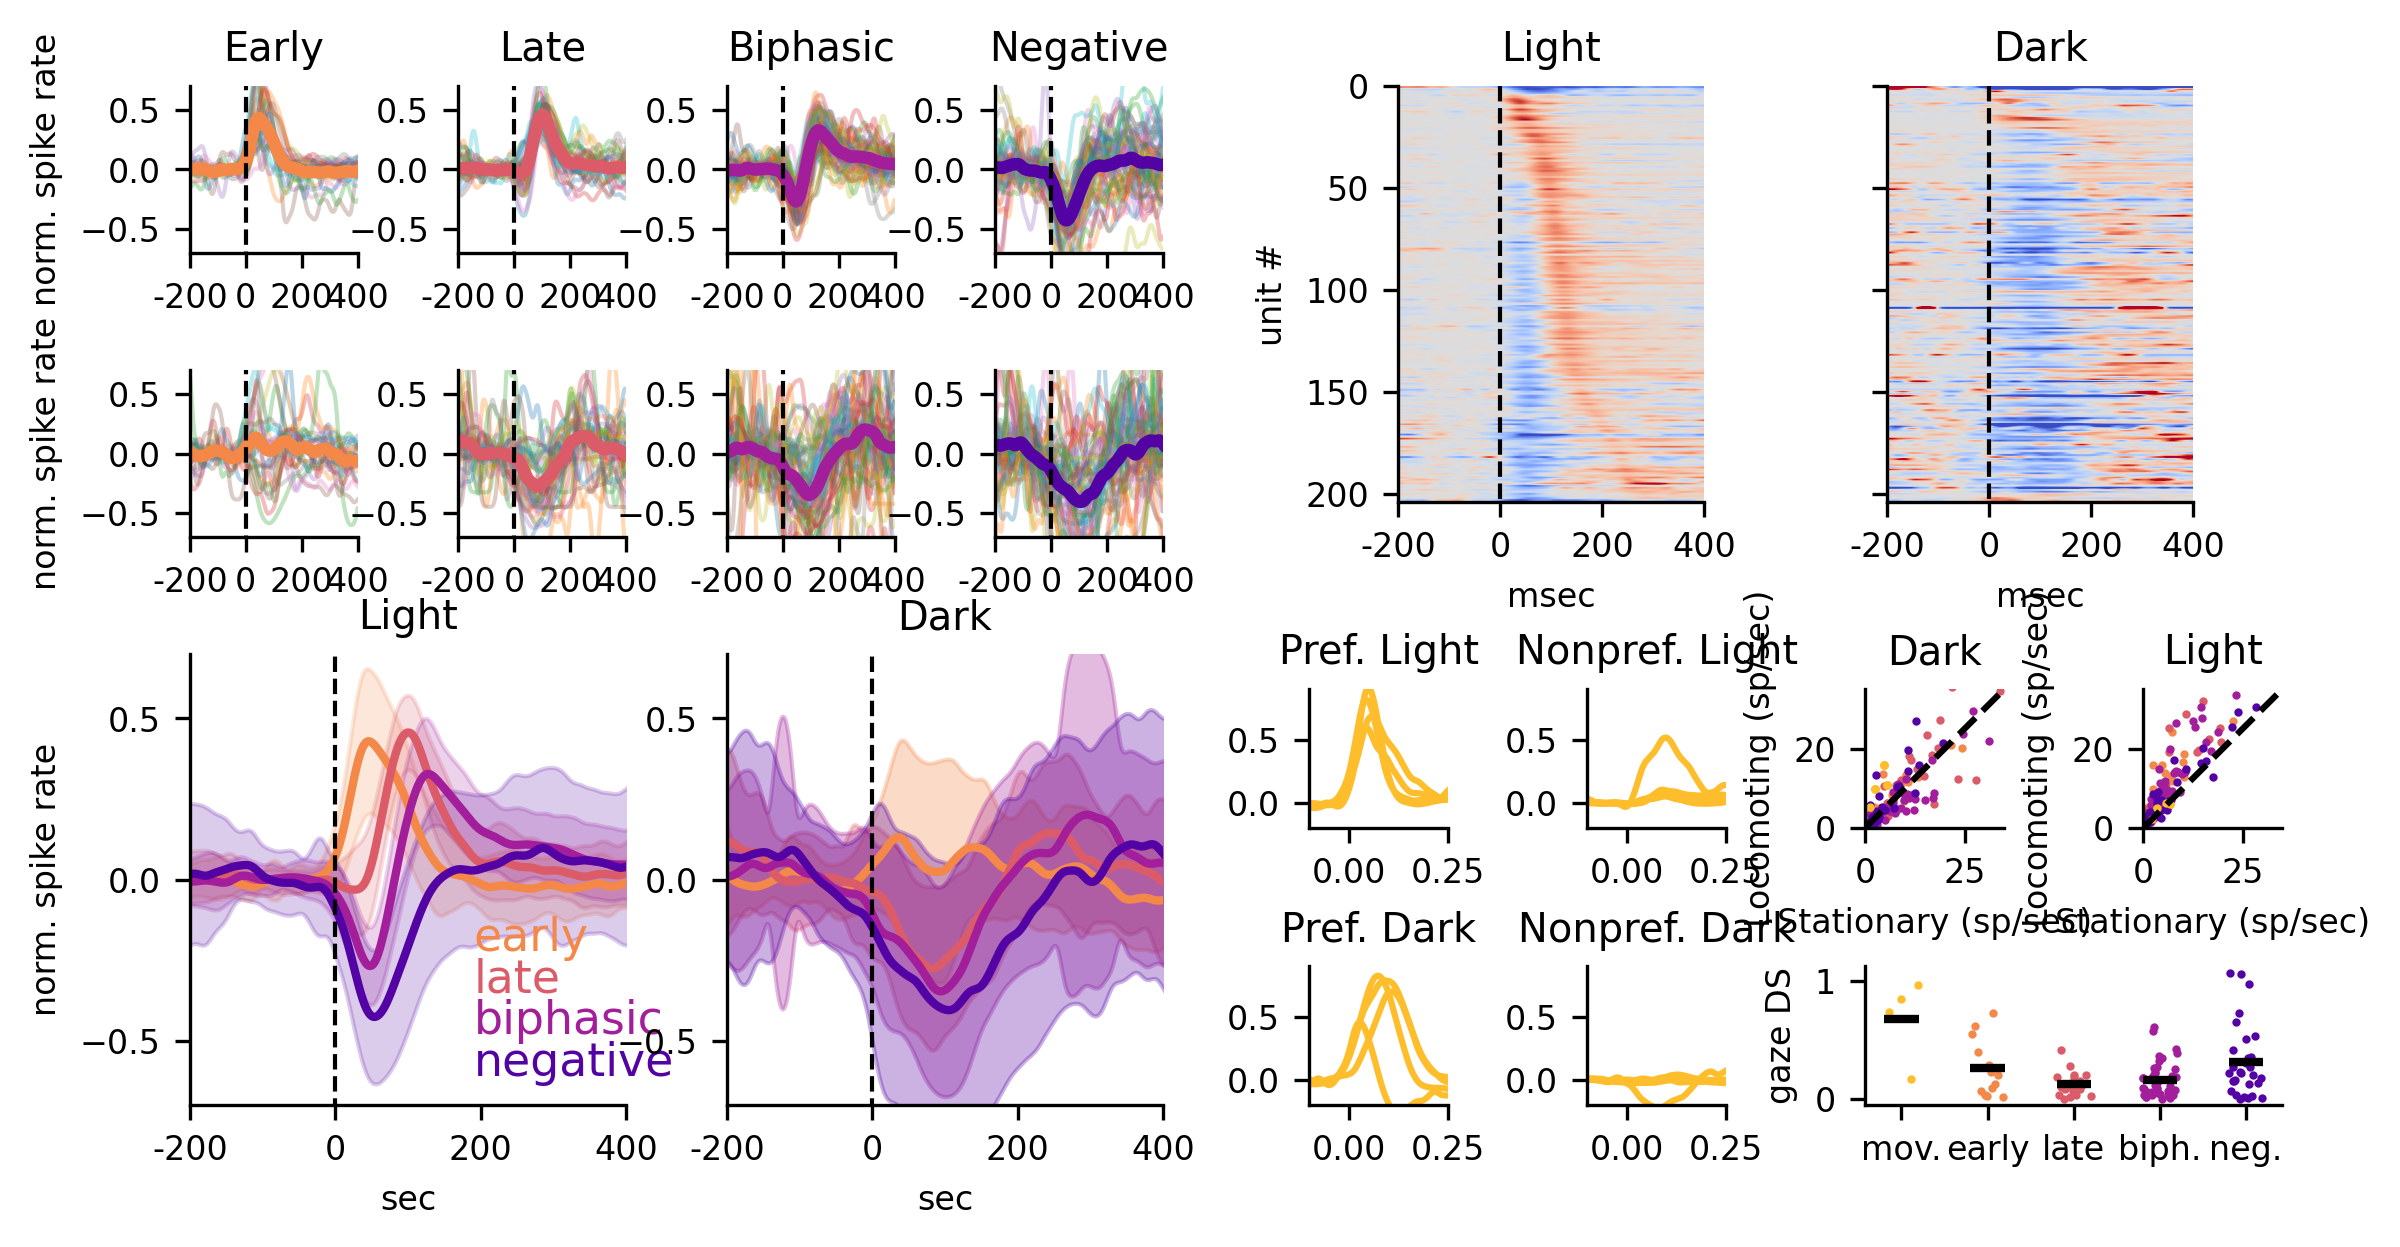

In [62]:
fig3 = plt.figure(constrained_layout=False, figsize=(9,4.5), dpi=300)
fig3spec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig3, wspace=0.15, hspace=0.45)

fig3A2Bspec = gridspec.GridSpecFromSubplotSpec(4,4, subplot_spec=fig3spec[:,0], wspace=0.6, hspace=0.7)
ax_early_l = fig3.add_subplot(fig3A2Bspec[0,0])
ax_late_l = fig3.add_subplot(fig3A2Bspec[0,1])
ax_biphasic_l = fig3.add_subplot(fig3A2Bspec[0,2])
ax_negative_l = fig3.add_subplot(fig3A2Bspec[0,3])

ax_early_d = fig3.add_subplot(fig3A2Bspec[1,0])
ax_late_d = fig3.add_subplot(fig3A2Bspec[1,1])
ax_biphasic_d = fig3.add_subplot(fig3A2Bspec[1,2])
ax_negative_d = fig3.add_subplot(fig3A2Bspec[1,3])

ax_light_clusters = fig3.add_subplot(fig3A2Bspec[2:4,0:2])
ax_dark_clusters = fig3.add_subplot(fig3A2Bspec[2:4,2:4])

fig3Cspec = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=fig3spec[0,1], wspace=0.01, hspace=0)
ax_tseq_l = fig3.add_subplot(fig3Cspec[:,0])
ax_tseq_d = fig3.add_subplot(fig3Cspec[:,1])

fig3D2Fspec = gridspec.GridSpecFromSubplotSpec(2,4, subplot_spec=fig3spec[1,1], wspace=1, hspace=1)
ax_active_light_pref = fig3.add_subplot(fig3D2Fspec[0,0])
ax_active_light_nonpref = fig3.add_subplot(fig3D2Fspec[0,1])
ax_active_dark_pref = fig3.add_subplot(fig3D2Fspec[1,0])
ax_active_dark_nonpref = fig3.add_subplot(fig3D2Fspec[1,1])

ax_stationary_fr = fig3.add_subplot(fig3D2Fspec[0,2])
ax_active_fr = fig3.add_subplot(fig3D2Fspec[0,3])
ax_gaze_ds = fig3.add_subplot(fig3D2Fspec[1,2:4])

step = 0.13
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth1'])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0)# / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.7,.7])
ax_light_clusters.annotate('early', xy=[0.19,-0.22], color=cat_cmap['early'], fontsize=11)
ax_light_clusters.annotate('late', xy=[0.19,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
ax_light_clusters.annotate('biphasic', xy=[0.19,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
ax_light_clusters.annotate('negative', xy=[0.19,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('sec')
ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth1_FmDk'])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0)# / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.7,.7]); ax_dark_clusters.set_xlabel('sec')
ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

light_panels = [ax_early_l, ax_late_l, ax_biphasic_l, ax_negative_l]
dark_panels = [ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d]

for count, name in enumerate(names):
    lpanel = light_panels[count]; dpanel = dark_panels[count]
    
    for x in ltdk.data['pref_gazeshift_psth1'][ltdk.data['movcluster']==name]:
        lpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    lpanel.plot(psth_bins, np.nanmean(flatten_series(ltdk.data['pref_gazeshift_psth1'][ltdk.data['movcluster']==name]),0), '-', linewidth=3, color=cat_cmap[name])
    lpanel.set_xlim([-0.2,0.4]); lpanel.set_ylim([-.7,.7])
    lpanel.set_title(name.capitalize())
    lpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    lpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    for x in ltdk.data['pref_gazeshift_psth1_FmDk'][ltdk.data['movcluster']==name]:
        dpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    dpanel.plot(psth_bins, np.nanmean(flatten_series(ltdk.data['pref_gazeshift_psth1_FmDk'][ltdk.data['movcluster']==name]),0), '-', linewidth=3, color=cat_cmap[name])
    dpanel.set_xlim([-0.2,0.4]); dpanel.set_ylim([-.7,.7])
    dpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    dpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    if name=='early':
        lpanel.set_ylabel('norm. spike rate'); dpanel.set_ylabel('norm. spike rate')
    
tseq_aspect = 4
plot_tempseq(ax_tseq_l, tseq_l)
ax_tseq_l.set_aspect(tseq_aspect)
ax_tseq_l.set_title('Light')
ax_tseq_l.set_ylabel('unit #')

plot_tempseq(ax_tseq_d, tseq_d)
ax_tseq_d.set_aspect(tseq_aspect)
ax_tseq_d.set_title('Dark')
ax_tseq_d.set_yticklabels([])

dark_responding = [61,73,183,186]
for ind in dark_responding:
    ax_active_light_pref.plot(psth_bins, ltdk.data.loc[ind,'pref_gazeshift_psth1'], color=cat_cmap['movement'])
    ax_active_light_nonpref.plot(psth_bins, ltdk.data.loc[ind,'nonpref_gazeshift_psth1'], color=cat_cmap['movement'])
    ax_active_dark_pref.plot(psth_bins, ltdk.data.loc[ind,'pref_gazeshift_psth1_FmDk'], color=cat_cmap['movement'])
    ax_active_dark_nonpref.plot(psth_bins, ltdk.data.loc[ind,'nonpref_gazeshift_psth1_FmDk'], color=cat_cmap['movement'])
ax_active_light_pref.set_xlim([-.1,0.25]); ax_active_light_pref.set_ylim([-.2,.9])
ax_active_light_pref.set_title('Pref. Light')
ax_active_dark_pref.set_xlim([-.1,0.25]); ax_active_dark_pref.set_ylim([-.2,.9])
ax_active_dark_pref.set_title('Pref. Dark')
ax_active_light_nonpref.set_xlim([-.1,0.25]); ax_active_light_nonpref.set_ylim([-.2,.9])
ax_active_light_nonpref.set_title('Nonpref. Light')
ax_active_dark_nonpref.set_xlim([-.1,0.25]); ax_active_dark_nonpref.set_ylim([-.2,.9])
ax_active_dark_nonpref.set_title('Nonpref. Dark')

for name in names:
    light_iafr = ltdk.data['FmLt_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_iafr = ltdk.data['FmDk_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    light_afr = ltdk.data['FmLt_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_afr = ltdk.data['FmDk_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    for i in range(np.size(light_iafr,0)):
        ax_active_fr.plot(light_iafr[i], light_afr[i], '.', color=cat_cmap[name], markersize=2)
        ax_stationary_fr.plot(dark_iafr[i], dark_afr[i], '.', color=cat_cmap[name], markersize=2)
        
    for ind in dark_responding:
        ax_stationary_fr.plot(ltdk.data.loc[ind,'FmLt_inactive_fr'], ltdk.data.loc[ind,'FmLt_active_fr'], '.', color=cat_cmap['movement'], markersize=2)
        ax_active_fr.plot(ltdk.data.loc[ind,'FmDk_inactive_fr'], ltdk.data.loc[ind,'FmDk_active_fr'], '.', color=cat_cmap['movement'], markersize=2)

fr_axis_max = 35
ax_stationary_fr.set_ylim([0,fr_axis_max]); ax_active_fr.set_ylim([0,fr_axis_max])
ax_stationary_fr.set_xlim([0,fr_axis_max]); ax_active_fr.set_xlim([0,fr_axis_max])
ax_stationary_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_active_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_stationary_fr.set_xlabel('Stationary (sp/sec)'); ax_stationary_fr.set_ylabel('Locomoting (sp/sec)')
ax_active_fr.set_title('Light')
ax_active_fr.set_xlabel('Stationary (sp/sec)'); ax_active_fr.set_ylabel('Locomoting (sp/sec)')
ax_stationary_fr.set_title('Dark')

for c, cluster in enumerate(['movement','early','late','biphasic','negative']):
    if cluster != 'movement':
        data = ltdk.data['gaze_sacc_rlMI'][ltdk.data['movcluster']==cluster].copy()
        if cluster=='early':
            data = data.drop(index=dark_responding).to_numpy()
    elif cluster == 'movement':
        data = ltdk.data.loc[dark_responding, 'gaze_sacc_rlMI'].copy().to_numpy()
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
    data = np.abs(data)
    ax_gaze_ds.plot(x_jitter, data, '.', color=cat_cmap[cluster], markersize=2)
    ax_gaze_ds.hlines(np.nanmean(data), c-0.2, c+0.2, color='k', linewidth=2)
    ax_gaze_ds.set_xticks(range(5), ['mov.','early','late','biph.','neg.'])
ax_gaze_ds.set_ylabel('gaze DS')

fig3.savefig('/home/niell_lab/Desktop/fig3.pdf')


# Fig 4

In [ ]:
fig4 = plt.figure(constrained_layout=False, figsize=(9,6), dpi=300)
fig4spec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig4, wspace=0, hspace=0)

fig4A2Bspec = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=fig4spec[:,0], wspace=0, hspace=0)
ax_pos_raster = fig4.add_subplot(fig4A2Bspec[0:2,0])
ax_biph_raster = fig4.add_subplot(fig4A2Bspec[0:2,1])
ax_neg_raster = fig4.add_subplot(fig4A2Bspec[0:2,2])
ax_pos_psth = fig4.add_subplot(fig4A2Bspec[2,0])
ax_biph_psth = fig4.add_subplot(fig4A2Bspec[2,1])
ax_neg_psth = fig4.add_subplot(fig4A2Bspec[2,2])

num_movements = 100
raster_panels = [ax_pos_raster, ax_biph_raster, ax_neg_raster]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.data.iloc[u]
    raster_panel = raster_panels[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead'.format(LR)].copy()
    compmovs = np.hstack([row['FmLt_comp_left_saccTimes_dHead'], row['FmLt_comp_right_saccTimes_dHead']])
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_cp = np.random.choice(compmovs, size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.vlines(sp, n-0.5, n+0.5, color='tab:orange')

    for n, s in enumerate(plot_cp):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.vlines(sp, (num_movements+n)-0.5, (num_movements+n)+0.5, color='tab:blue')
    
    height = num_movements*2
    raster_panel.set_ylim([height, 0])
    raster_panel.vlines(0, 0, height, color='k', linewidth=2, linestyle='dotted')
    raster_panel.set_xlabel('msec')
    if i == 0:
        raster_panel.set_ylabel('eye movement')
    else:
        raster_panel.set_yticks([])
    raster_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    raster_panel.set_title(['Positive','Biphasic','Negative'][i])
    raster_panel.set_xlim([-.5,.5])
    
    sdf_panel.plot(psth_bins, row['FmLt_comp_{}_saccPSTH_dHead'.format(LR)], color='tab:blue')
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], color='tab:orange')
    max_fr = np.nanmax(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)])*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('sp/sec')
    sdf_panel.set_xlabel('msec')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=2, linestyle='dotted')

In [71]:
[x for x in hffm.data.columns.values if 'Rc' in x]

['Rc_n_spikes',
 'Rc_spikeT',
 'Rc_spikeTraw',
 'Rc_rate',
 'Rc_contrast',
 'Rc_contrast_tuning_bins',
 'Rc_contrast_tuning',
 'Rc_contrast_tuning_err',
 'Rc_spike_triggered_average',
 'Rc_spike_triggered_variance',
 'Rc_rightsacc_avg',
 'Rc_leftsacc_avg',
 'Rc_pupilradius_tuning_bins',
 'Rc_pupilradius_tuning',
 'Rc_pupilradius_tuning_err',
 'Rc_theta_tuning_bins',
 'Rc_theta_tuning',
 'Rc_theta_tuning_err',
 'Rc_phi_tuning_bins',
 'Rc_phi_tuning',
 'Rc_phi_tuning_err',
 'Rc_eyeT',
 'Rc_dEye_dpf',
 'Rc_dEye_dps',
 'Rc_theta',
 'Rc_phi',
 'Rc_ballspeed',
 'Rc_ballspeed_tuning_bins',
 'Rc_ballspeed_tuning',
 'Rc_ballspeed_tuning_err',
 'Rc_response_by_channel',
 'Rc_current_source_density',
 'Rc_relative_depth',
 'Rc_layer4cent',
 'Rc_lfp_power',
 'Rc_layer5cent_from_lfp',
 'Rc_ch_lfp_relative_depth',
 'Rc_depth_from_layer4',
 'Rc_psth',
 'norm_Rc_psth']